# Ex ? Manipulating Spectra Part 2 - `Spectra`

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

In [2]:
%matplotlib inline

In [3]:
%autoreload


import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt

import pickle

import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp2d

import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.pppc as pppc
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra

import main
import config

In [10]:
config.load_data('dep_tf')

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******


{'highengphot': <darkhistory.spec.transferfunclist.TransferFuncInterp at 0x10e79cf28>,
 'lowengphot': <darkhistory.spec.transferfunclist.TransferFuncInterp at 0x10e79c5f8>,
 'lowengelec': <darkhistory.spec.transferfunclist.TransferFuncInterp at 0x10e79c6d8>,
 'highengdep': <darkhistory.history.histools.IonRSInterp at 0x10e7a7080>,
 'CMB_engloss': <darkhistory.history.histools.IonRSInterp at 0x10e7a7e80>}

In [30]:
import copy

# a = copy.deepcopy(config.glob_dep_tf_data['highengphot'])

for i,grid in enumerate(a.grid_vals):
    a.grid_vals[i] = grid.astype(np.float32)
    print(a.grid_vals[i].dtype)

float32
float32
float32


In [18]:
for grid in config.glob_dep_tf_data['lowengphot'].grid_vals:
    grid = grid.astype('float32')

In [19]:
for grid in config.glob_dep_tf_data['lowengelec'].grid_vals:
    grid = grid.astype('float32')

In [35]:
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size


def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


In [36]:
pickle_dump(
    a,'/Users/hongwan/Dropbox (MIT)/Photon Deposition/DarkHistory_data/highengphot_tf_interp_flt32.raw'
)
# pickle.dump(
#     config.glob_dep_tf_data['lowengphot'], 
#     open('/Users/hongwan/Dropbox (MIT)/Photon Deposition/DarkHistory_data/lowengphot_tf_interp_flt32.raw','wb')
# )
# pickle.dump(
#     config.glob_dep_tf_data['lowengelec'], 
#     open('/Users/hongwan/Dropbox (MIT)/Photon Deposition/DarkHistory_data/lowengelec_tf_interp_flt32.raw','wb')
# )

writing total_bytes=6147008275...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing bytes [2147483648, 3221225472)... done.
writing bytes [3221225472, 4294967296)... done.
writing bytes [4294967296, 5368709120)... done.
writing bytes [5368709120, 6147008275)... done.


In [7]:
photeng = 10**np.arange(-4, 12, 0.05)
a = pppc.get_pppc_spec(100e9, photeng, 'gamma', 'phot')
b = pppc.get_pppc_spec(100e9, photeng, 'gamma', 'elec')

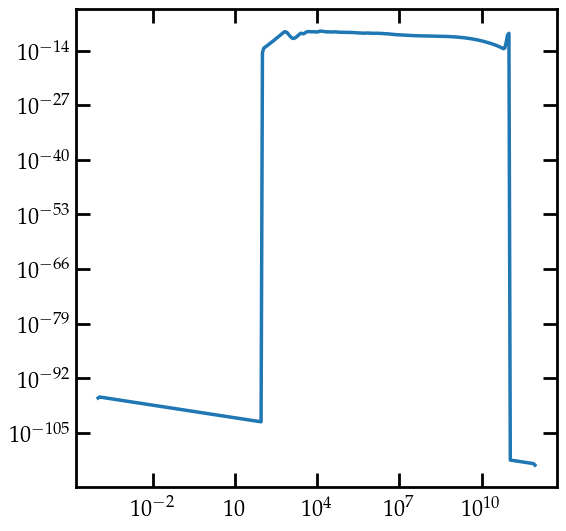

In [8]:
plt.figure()
plt.loglog()

plt.plot(photeng, a.dNdE)

In [9]:
a.toteng()/200e9 + b.toteng()/200e9

0.9637422496311827

In [ ]:
f_elec_CMB_raw = np.loadtxt(config.data_path+'/fFromIonBaseline3keV_electron_extended.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1] 

f_phot_CMB_raw = np.loadtxt(config.data_path+'/fFromIonBaseline3keV_photon.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1] 

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

def xsec_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]


In [ ]:
max_xsec = xsec_bound_phot_CMB(1e6, 'swave')

In [ ]:
# result_no_BR = main.evolve(
#             primary='phot_delta',
#             DM_process='decay', mDM=1e7, lifetime = 3e24,
#             start_rs = 3000, end_rs=17,
#             coarsen_factor=4, backreaction=False
#         )

mDM_arr = 10**np.arange(4.01, 6.26, 0.25)

# result_no_BR = [ 
#     main.evolve(
#         primary='phot_delta',
#         DM_process='swave', mDM=mDM, sigmav = xsec_bound_phot_CMB(mDM, 'swave'),
#         start_rs = 3000, end_rs=4.1,
#         coarsen_factor=4, backreaction=False, 
#         struct_boost = phys.struct_boost_func()
#     ) for mDM in mDM_arr
# ]

result_BR = [
    main.evolve(
        primary='phot_delta',
        DM_process='swave', mDM=mDM, sigmav = xsec_bound_phot_CMB(mDM, 'swave'),
        start_rs = 3000, end_rs=4.1,
        coarsen_factor=4, backreaction=True, 
        struct_boost = phys.struct_boost_func()
    ) for mDM in mDM_arr
]

In [ ]:
Tm_no_BR = np.array([res['Tm'] for res in result_no_BR])
Tm_BR    = np.array([res['Tm'] for res in result_BR])

In [ ]:
import darkhistory.utilities as utils

utils.compare_arr([Tm_no_BR[0], Tm_BR[0]])

In [ ]:
plt.figure()

plt.loglog()

frac_change_levels = [1e-5, .1, .5, 1, 2, 5, 10, 20, 40]

plt.contour(
    mDM_arr, result_no_BR[0]['rs'], np.transpose((Tm_BR/Tm_no_BR - 1.)*100),
    frac_change_levels,
    norm=matplotlib.colors.LogNorm(),
    cmap=matplotlib.cm.inferno
)

plt.axis([1e4, 5e12, 4.1, 200])

In [ ]:
test = main.evolve(
        primary='elec_delta',
        DM_process='swave', mDM=1e6, sigmav = xsec_bound_phot_CMB(1e6, 'swave'),
        start_rs = 3000, end_rs=4.004,
        coarsen_factor=12, backreaction=True, 
        struct_boost = phys.struct_boost_func()
) 

In [ ]:
test['rs'].size

In [ ]:
utils.compare_arr([3000*np.exp(-.012*np.arange(552)) , test['rs']])

In [ ]:
plt.figure()

# plt.loglog()

plt.plot(result_no_BR['rs'], result_BR['Tm']/result_no_BR['Tm'] - 1)

plt.axis([1, 20, 0, 0.5])

In [ ]:
inj_str = 'elec'
inj_type = 'swave'
extra = ''

f_DH_list_new = pickle.load(open('/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                   +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck_LowPHigh.p','rb')
                  )

In [ ]:
print(f_DH_list_new.shape)
print(eng_arr.shape)
print(rs_vec.shape)


In [ ]:
rs_vec = 3000*np.exp(-.001*np.arange(6620))
eng_arr = 5e3*10**(np.arange(40)*0.23252559)
eng_arr[-1]=10**12.60150599

plt.figure()

plt.loglog()

# plt.contour(eng_arr, rs_vec, np.transpose(np.log10(f_DH_list[:,:,0])), levels=np.log10([0.01, 0.1, 0.2, 0.5, 1, 5, 10, 50]))
# plt.contour(eng_arr, rs_vec, np.transpose(np.log10(f_elec_swave_heat)), levels=np.log10(np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10])))

plt.contour(
    eng_arr, rs_vec, np.transpose(np.log10(f_DH_list_new[:,0,:])), 
    levels=np.log10(np.array([10])), 
#     colors='k', linestyles='dashed'
)



In [ ]:
f_phot_swave_heat = np.array(f_phot_swave_heat)
print(f_phot_swave_heat.shape)

In [ ]:
from tqdm import tqdm_notebook as tqdm

%autoreload
f_phot_swave_heat = [
    [
        phys.f_std(eng, rs, inj_particle='phot', inj_type='swave', channel='heat', struct=True)
        for rs in rs_vec
    ]
    for eng in tqdm(eng_arr)
]


 

In [ ]:
import main

result = main.evolve(
            primary='elec_delta',
            DM_process='swave', mDM=eng_arr[10] + phys.me, sigmav = 3e-26,
            start_rs = 3000, end_rs=5.1,
            coarsen_factor=12, backreaction=False,
            struct_boost = phys.struct_boost_func('einasto_with_subs')
        )

In [ ]:
result['f']['high']

In [ ]:
plt.figure()

plt.loglog()

plt.plot(result['rs'], result['f']['low']['H ion'] + result['f']['high']['H ion'], 'k--')
plt.plot(rs_vec, f_DH_list_new[10,0,:])
plt.axis([4, 4000, 10**(-3.5), 1000])

In [ ]:
eng_arr[10]

In [ ]:
eng = np.array([1, 10, 100, 1000])
spec_arr = [Spectrum(eng, np.ones(4)*i, rs=100, spec_type='N') for i in np.arange(4)]
test_spectra = Spectra(spec_arr)
test_spectra.redshift(np.array([0.01, 0.1, 1, 10]))
print(test_spectra.grid_vals)

In [ ]:
a = Spectrum(eng, np.ones(4)*3, rs=100, spec_type='N') 
a.totN(bound_type='bin')

In [ ]:
0.5*13*10 + 14*100 + 15*1000

In [ ]:
9*0.5 + 10 + 11

In [ ]:
12*1 + 13*10 + 14*100 + 15*1000

In [ ]:
1*10 + 2*100

In [ ]:
%autoreload 2
phys.Tm_std(100)

In [ ]:
a = phys.struct_boost_func()

In [ ]:
a(1)

In [ ]:
%autoreload
phys.f_std(3e5, 300, inj_particle='phot', inj_type='decay', channel='heat')

In [ ]:
from config import load_data

In [ ]:
a = load_data('dep_tf')

In [ ]:
hep_tf = a['highengphot']
lep_tf  = a['lowengphot']
lee_tf  = a['lowengelec']

In [ ]:
%%cython

def coarsen_matrices(hep, lep, lee, cf):
    prop_tf = np.zeros_like(hep)
    for i in np.arange(cf):
        prop_tf += np.linalg.matrix_power(hep, i)
    lep = np.matmul(prop_tf, lep)
    lee = np.matmul(prop_tf, lee)
    hep = np.linalg.matrix_power(hep, cf)



In [ ]:
from tqdm import tqdm_notebook as tqdm

cf = 12

for (hep_reg, lep_reg, lee_reg) in zip(hep_tf.grid_vals, lep_tf.grid_vals, lee_tf.grid_vals):
    for (hep_dim_1, lep_dim_1, lee_dim_1) in zip(tqdm(hep_reg), lep_reg, lee_reg):
        if hep_dim_1.ndim == 2:
            coarsen_matrices(hep_dim_1, lep_dim_1, lee_dim_1, cf)
        else:
            for (hep_dim_2, lep_dim_2, lee_dim_2) in zip(tqdm(hep_dim_1), lep_dim_1, lee_dim_1):
                if hep_dim_2.ndim == 2:
                    coarsen_matrices(hep_dim_2, lep_dim_2, lee_dim_2, cf)
                else:
                    for (hep_dim_3, lep_dim_3, lee_dim_3) in zip(hep_dim_2, lep_dim_2, lee_dim_2):
                        coarsen_matrices(hep_dim_3, lep_dim_3, lee_dim_3, cf)
        
            